## The focus of the notebook is to examine if there is any improvement of the Order Match Time after introducing a change of the Order Allocation System

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import datetime as dt
import scipy.stats as st
import statsmodels as sm
import warnings
import gc

%matplotlib inline 
plt.style.use('ggplot')

response = pd.read_csv('response_data.csv')

In [2]:
gc.collect()

11

## Data preprocessing

In [3]:
# check variables type
response.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
Driver Response Timestamp    5000 non-null object
Order Create Timestamp       5000 non-null object
Order Id                     5000 non-null int64
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [4]:
# check if there is any null values
response.isnull().sum()

Driver Response Timestamp    0
Order Create Timestamp       0
Order Id                     0
dtype: int64

In [5]:
# have a look of the original data
response.head(10)

,Driver Response Timestamp,Order Create Timestamp,Order Id
0,3/24/17 22:58:31,3/24/17 22:57:38,1
1,3/25/17 1:04:53,3/25/17 1:04:53,2
2,3/25/17 1:06:16,3/25/17 1:06:16,3
3,3/25/17 1:08:40,3/25/17 1:07:03,4
4,3/25/17 2:34:18,3/25/17 2:34:08,5
5,3/25/17 3:41:19,3/25/17 3:41:05,6
6,3/25/17 4:13:57,3/25/17 4:13:44,7
7,3/25/17 4:43:32,3/25/17 4:43:11,8
8,3/25/17 4:47:57,3/25/17 4:47:05,9
9,3/25/17 5:04:46,3/25/17 5:04:37,10


In [6]:
# change the order timestamp to datetime format
# create duration variables in seconds and minutes

response['Driver Response Timestamp'] = pd.to_datetime(response['Driver Response Timestamp'])
response['Order Create Timestamp'] = pd.to_datetime(response['Order Create Timestamp'])
response['Duration'] = response['Driver Response Timestamp'] - response['Order Create Timestamp']
response['Duration'] = response['Duration'].dt.total_seconds()
response['Duration [min]'] = response['Duration'] / 60.0

# create variables in hours, days and day of week

response['Order hour'] = response['Order Create Timestamp'].dt.hour
response['Order dayOfweek'] = response['Order Create Timestamp'].dt.weekday
response['Order day'] = response['Order Create Timestamp'].dt.day

# create duration since last order

response['Duration last order'] = response['Order Create Timestamp'] - response['Order Create Timestamp'].shift(1)
response['Duration last order'] = response['Duration last order'].dt.total_seconds()
response['Duration last order [min]'] = response['Duration last order'] / 60.0

In [7]:
response.head(5)

,Driver Response Timestamp,Order Create Timestamp,Order Id,Duration,Duration [min],Order hour,Order dayOfweek,Order day,Duration last order,Duration last order [min]
0,2017-03-24 22:58:31,2017-03-24 22:57:38,1,53.0,0.883333,22,4,24,NaN,NaN
1,2017-03-25 01:04:53,2017-03-25 01:04:53,2,0.0,0.000000,1,5,25,7635.0,127.250000
2,2017-03-25 01:06:16,2017-03-25 01:06:16,3,0.0,0.000000,1,5,25,83.0,1.383333
3,2017-03-25 01:08:40,2017-03-25 01:07:03,4,97.0,1.616667,1,5,25,47.0,0.783333
4,2017-03-25 02:34:18,2017-03-25 02:34:08,5,10.0,0.166667,2,5,25,5225.0,87.083333


In [8]:
# fill the first nan value with mean in columns for Duration last order
response['Duration last order'].fillna((response['Duration last order'].mean()), inplace=True)
response['Duration last order [min]'].fillna((response['Duration last order [min]'].mean()), inplace=True)

In [9]:
response.head(5)

,Driver Response Timestamp,Order Create Timestamp,Order Id,Duration,Duration [min],Order hour,Order dayOfweek,Order day,Duration last order,Duration last order [min]
0,2017-03-24 22:58:31,2017-03-24 22:57:38,1,53.0,0.883333,22,4,24,170.363473,2.839391
1,2017-03-25 01:04:53,2017-03-25 01:04:53,2,0.0,0.000000,1,5,25,7635.000000,127.250000
2,2017-03-25 01:06:16,2017-03-25 01:06:16,3,0.0,0.000000,1,5,25,83.000000,1.383333
3,2017-03-25 01:08:40,2017-03-25 01:07:03,4,97.0,1.616667,1,5,25,47.000000,0.783333
4,2017-03-25 02:34:18,2017-03-25 02:34:08,5,10.0,0.166667,2,5,25,5225.000000,87.083333


In [10]:
# get to know the basic stats
response[['Duration','Duration [min]','Duration last order','Duration last order [min]']].describe()

,Duration,Duration [min],Duration last order,Duration last order [min]
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,48.891200,0.814853,170.363473,2.839391
std,212.811331,3.546856,869.361950,14.489366
min,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.150000,25.750000,0.429167
50%,12.000000,0.200000,63.000000,1.050000
75%,26.000000,0.433333,132.000000,2.200000
max,4102.000000,68.366667,26820.000000,447.000000


In [11]:
# check the percentile of duration at the upper end
for i in range(90,100,2):
    print('Percentile {}th: {:.2f}'.format(i, np.percentile(response['Duration'], i)))

Percentile 90th: 54.00
Percentile 92th: 59.00
Percentile 94th: 74.00
Percentile 96th: 123.12
Percentile 98th: 420.00


### The mean of the order match time was 48.89 seconds and the median was 12 seconds. The maximum order match time was 4102 seconds which is 80 folds of the mean. The 98th percentile was only 420 seconds. We can consider removing some outliers in the dataset to calculate test statistics later.

In [12]:
# check how many zeroes in Duration
print('Zeroes in Order Match time: {}'.format(response[response['Duration'] == 0].shape[0]))

Zeroes in Order Match time: 23


In [13]:
# show the records of zeroes order match time 
response[response['Duration'] == 0]

,Driver Response Timestamp,Order Create Timestamp,Order Id,Duration,Duration [min],Order hour,Order dayOfweek,Order day,Duration last order,Duration last order [min]
1,2017-03-25 01:04:53,2017-03-25 01:04:53,2,0.0,0.0,1,5,25,7635.0,127.250000
2,2017-03-25 01:06:16,2017-03-25 01:06:16,3,0.0,0.0,1,5,25,83.0,1.383333
1046,2017-03-27 10:05:50,2017-03-27 10:05:50,1047,0.0,0.0,10,0,27,30.0,0.500000
1128,2017-03-27 11:14:08,2017-03-27 11:14:08,1129,0.0,0.0,11,0,27,45.0,0.750000
1376,2017-03-28 04:25:01,2017-03-28 04:25:01,1377,0.0,0.0,4,1,28,530.0,8.833333
1432,2017-03-28 06:13:03,2017-03-28 06:13:03,1433,0.0,0.0,6,1,28,24.0,0.400000
1523,2017-03-28 07:46:33,2017-03-28 07:46:33,1524,0.0,0.0,7,1,28,8.0,0.133333
1656,2017-03-28 10:13:06,2017-03-28 10:13:06,1657,0.0,0.0,10,1,28,87.0,1.450000
1874,2017-03-28 14:02:57,2017-03-28 14:02:57,1875,0.0,0.0,14,1,28,92.0,1.533333
1916,2017-03-28 15:01:36,2017-03-28 15:01:36,1917,0.0,0.0,15,1,28,53.0,0.883333


### There were 23 records with zero order match time, it is relatively small comparing to total records of 5000. Perhaps there is an option for drivers to select for matching any new order automatically. So let's keep them in the dataset for the purpose of this study.

### Seperate records before and after system change at 2017-03-30 12:00:00 AM

In [14]:
# create a dataframe with response before the change of Order Allocation system
response_prior = response[response['Order Create Timestamp'] < pd.to_datetime('2017-03-30 00:00:00')]

# create a dataframe with response after the change of Order Allocation system
response_post = response[response['Order Create Timestamp'] >= pd.to_datetime('2017-03-30 00:00:00')]
#[response['Duration']!=0]

### Check if our records make sense, have a look of the cutoff area, the tail of the records before system change and the head of the records after system change. (records sorted)

In [15]:
# just to make sure data are all sorted by datetime for easier checking
response.sort_values(by='Order Create Timestamp', inplace=True)

In [16]:
response_prior.tail(5)

,Driver Response Timestamp,Order Create Timestamp,Order Id,Duration,Duration [min],Order hour,Order dayOfweek,Order day,Duration last order,Duration last order [min]
2593,2017-03-29 18:27:04,2017-03-29 18:26:56,2594,8.0,0.133333,18,2,29,486.0,8.100000
2594,2017-03-29 18:27:15,2017-03-29 18:27:07,2595,8.0,0.133333,18,2,29,11.0,0.183333
2595,2017-03-29 18:32:30,2017-03-29 18:32:22,2596,8.0,0.133333,18,2,29,315.0,5.250000
2596,2017-03-29 18:44:05,2017-03-29 18:43:51,2597,14.0,0.233333,18,2,29,689.0,11.483333
2597,2017-03-29 19:05:43,2017-03-29 19:05:35,2598,8.0,0.133333,19,2,29,1304.0,21.733333


In [17]:
response_post.head(5)

,Driver Response Timestamp,Order Create Timestamp,Order Id,Duration,Duration [min],Order hour,Order dayOfweek,Order day,Duration last order,Duration last order [min]
2598,2017-03-30 02:33:33,2017-03-30 02:32:35,2599,58.0,0.966667,2,3,30,26820.0,447.000000
2599,2017-03-30 02:40:47,2017-03-30 02:40:13,2600,34.0,0.566667,2,3,30,458.0,7.633333
2600,2017-03-30 02:45:19,2017-03-30 02:44:01,2601,78.0,1.300000,2,3,30,228.0,3.800000
2601,2017-03-30 02:56:25,2017-03-30 02:55:51,2602,34.0,0.566667,2,3,30,710.0,11.833333
2602,2017-03-30 03:05:39,2017-03-30 03:03:45,2603,114.0,1.900000,3,3,30,474.0,7.900000


In [18]:
# counts of records before and after the system change
print('Total records before the system change: {}'.format(response_prior.shape[0]))
print('Total records after the system change: {}'.format(response_post.shape[0]))

Total records before the system change: 2598
Total records after the system change: 2402


In [19]:
# Show unique dates
list = response['Order Create Timestamp'].map(pd.Timestamp.date).unique().tolist()
print(len(list))
list

11


[datetime.date(2017, 3, 24),
 datetime.date(2017, 3, 25),
 datetime.date(2017, 3, 26),
 datetime.date(2017, 3, 27),
 datetime.date(2017, 3, 28),
 datetime.date(2017, 3, 29),
 datetime.date(2017, 3, 30),
 datetime.date(2017, 3, 31),
 datetime.date(2017, 4, 1),
 datetime.date(2017, 4, 2),
 datetime.date(2017, 4, 3)]

### We only have records from 11 unique days
<br>

## Question a) What is the resulting impact from this change?
### Order Match Time: before and after system change 

In [20]:
label = ['Duration', 'Duration [min]']

In [21]:
response_prior[label].describe()

,Duration,Duration [min]
count,2598.000000,2598.000000
mean,47.854888,0.797581
std,216.946677,3.615778
min,0.000000,0.000000
25%,9.000000,0.150000
50%,12.500000,0.208333
75%,25.000000,0.416667
max,4102.000000,68.366667


In [22]:
response_post[label].describe()

,Duration,Duration [min]
count,2402.000000,2402.000000
mean,50.012073,0.833535
std,208.285455,3.471424
min,0.000000,0.000000
25%,9.000000,0.150000
50%,11.000000,0.183333
75%,26.000000,0.433333
max,3945.000000,65.750000


### At first glance, the median of the order match time after system change (11 secs) was smaller than that before system change (12.5 secs). The maximum order match time (3945 secs) was also smaller than that before system change (4102 secs). The standard deviation improved (208.29 secs) vs. (216.95 secs). However, the mean order match time was higher than that before system change. Perhaps there were more order match time in the upper end of the distribution.

In [23]:
# check the percentile at the upper end
for i in range(90,100,2):
    print('Records (Prior) {}th percentile: {:.2f} | Number of records larger than {}th percentile: {}'
          .format(i, np.percentile(response_prior['Duration'], i), i,
                                   response_prior[response_prior['Duration'] > np.percentile(response_prior['Duration'], i)].shape[0] ))
print('\n')
for i in range(90,100,2):
    print('Records (post) {}th percentile: {:.2f} | Number of records larger than {}th percentile: {}'
          .format(i, np.percentile(response_post['Duration'], i), i,
                                   response_post[response_post['Duration'] > np.percentile(response_post['Duration'], i)].shape[0] ))
    

Records (Prior) 90th percentile: 52.00 | Number of records larger than 90th percentile: 238
Records (Prior) 92th percentile: 54.00 | Number of records larger than 92th percentile: 207
Records (Prior) 94th percentile: 63.00 | Number of records larger than 94th percentile: 153
Records (Prior) 96th percentile: 101.00 | Number of records larger than 96th percentile: 103
Records (Prior) 98th percentile: 384.26 | Number of records larger than 98th percentile: 52


Records (post) 90th percentile: 57.00 | Number of records larger than 90th percentile: 235
Records (post) 92th percentile: 65.92 | Number of records larger than 92th percentile: 193
Records (post) 94th percentile: 82.94 | Number of records larger than 94th percentile: 145
Records (post) 96th percentile: 144.96 | Number of records larger than 96th percentile: 97
Records (post) 98th percentile: 509.40 | Number of records larger than 98th percentile: 49


### Let's plot the Order Match Time <= 90th percentile for better visualization.

In [24]:
# creating dataframes with duration smaller or equal to 90th percentile
response_prior2 = response_prior[response_prior['Duration']<=np.percentile(response_prior['Duration'], 90)].reset_index(drop=True)
response_post2 = response_post[response_post['Duration']<=np.percentile(response_post['Duration'], 90)].reset_index(drop=True)

In [25]:
# some basics stats of records <= 90th percentile
response_prior2[label].describe()

,Duration,Duration [min]
count,2360.000000,2360.000000
mean,16.625847,0.277097
std,11.299398,0.188323
min,0.000000,0.000000
25%,9.000000,0.150000
50%,11.000000,0.183333
75%,22.000000,0.366667
max,52.000000,0.866667


In [26]:
# some basics stats of records <= 90th percentile
response_post2[label].describe()

,Duration,Duration [min]
count,2167.000000,2167.000000
mean,16.419474,0.273658
std,12.621665,0.210361
min,0.000000,0.000000
25%,8.000000,0.133333
50%,10.000000,0.166667
75%,21.000000,0.350000
max,57.000000,0.950000


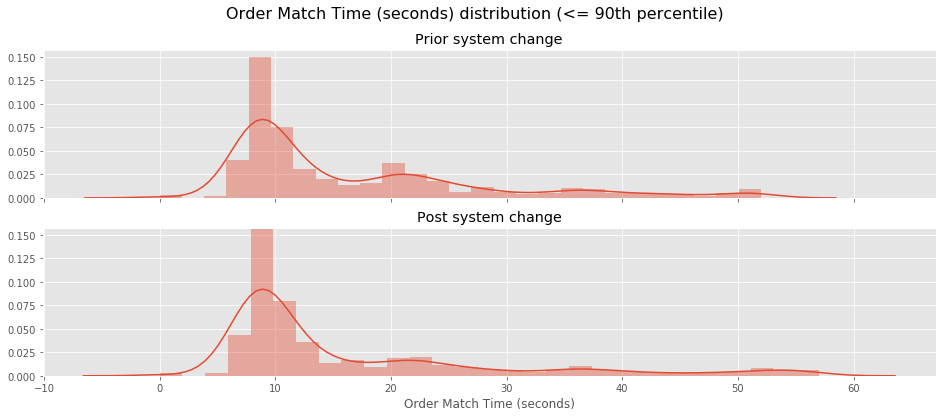

In [27]:
fig, ax = plt.subplots(nrows=2,sharex='col',sharey=True, figsize=(16,6))
sns.distplot(response_prior2['Duration'], ax=ax[0])
sns.distplot(response_post2['Duration'], ax=ax[1])
ax[0].set_xlabel('')
ax[1].set_xlabel('Order Match Time (seconds)',fontsize=12)
ax[0].set_title('Prior system change')
ax[1].set_title('Post system change')
fig.suptitle('Order Match Time (seconds) distribution (<= 90th percentile)', fontsize=16)
plt.show()

### The histogram and kernel density plot are quite similar and it is hard to tell the difference. On the good side, we know that the distributions were somewhat the same! The distributions were not normally distributed and more like exponential distributions (good information for test statistics). Now let's checkout some boxplots to see if we can find something.

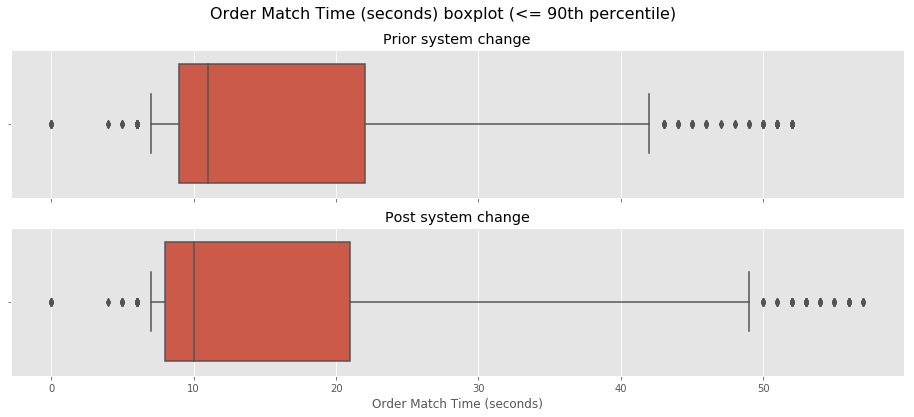

In [28]:
fig, ax = plt.subplots(nrows=2,sharex='col',sharey=True, figsize=(16,6))
sns.boxplot(x=response_prior2['Duration'], whis=[5, 95], ax=ax[0])
sns.boxplot(x=response_post2['Duration'], whis=[5, 95], ax=ax[1])
ax[0].set_xlabel('')
ax[1].set_xlabel('Order Match Time (seconds)',fontsize=12)
ax[0].set_title('Prior system change')
ax[1].set_title('Post system change')
fig.suptitle('Order Match Time (seconds) boxplot (<= 90th percentile)', fontsize=16)
plt.show()

### From the boxplot we can tell there is a shift of the distribution, the 25% percentile, median and 75% percentile shifted lower! So there seemed to be improvement from the system change! There were more large order match time after post system change though. To check how confident we are about the shifting of distribution. let's perform some test statistics!

### From the visualization, we get that the order match time were probably not normally distributed. Normally, if the subjects are normally distributed, we could perform t-test. For this unknown distribution (perhaps exponential), we will perform non-parametric test (does not require the assumption of normal distribution) to compare the distributions. 

### One-tailed Mann-Whitney U Test (To check the shift of direction)

### Assumptions: 
#### 1.) All the observations are independent of each other. 
#### 2.) Dependent variables (Order match time) are ordinal.
#### 3.) Independent variables (System change) are categorical
#### 4.) Data are not normally distributed, two distributions have the same shape (Can tell from the plots above)
<br>
#### Null hypothesis: both distributions are the same
#### Alternative hypothesis: prior distribution is greater than the post distribution
#### Alpha = 2.5%
#### Decision rule: reject null hypothesis if p-value is lower than 2.5%

### For records lower or equal 90th percentile

In [29]:
print('(<=90th percentile) Mann Whitney U Test statistics and P-value: {} and {}'.format( 
    st.mannwhitneyu(response_prior2['Duration'], response_post2['Duration'], alternative='greater')[0],
    st.mannwhitneyu(response_prior2['Duration'], response_post2['Duration'], alternative='greater')[1]))

(<=90th percentile) Mann Whitney U Test statistics and P-value: 2684127.5 and 0.001833337430150406


### For all records

In [30]:
print(' (All records) Mann Whitney U Test statistics and P-value: {} and {}'.format( 
    st.mannwhitneyu(response_prior['Duration'], response_post['Duration'], alternative='greater')[0],
    st.mannwhitneyu(response_prior['Duration'], response_post['Duration'], alternative='greater')[1]))

 (All records) Mann Whitney U Test statistics and P-value: 3220515.0 and 0.024212376887505993


In [31]:
# Just to calculate z-stat since if sample size is large, the U statistic approximates normal distribution

u, prob = st.mannwhitneyu(response_prior['Duration'], response_post['Duration'], alternative='greater')
x = response_prior['Duration']
y = response_post['Duration']

m_u = len(x)*len(y)/2

sigma_u = np.sqrt(len(x)*len(y)*(len(x)+len(y)+1)/12)

z = (u - m_u)/sigma_u
print('Z-statistic: {} > 1.96 (critical value for one tailed test with alpha 2.5%)'.format(z))

Z-statistic: 1.9671191073360033 > 1.96 (critical value for one tailed test with alpha 2.5%)


### Median of order match time before and after system change were 12.5 secs and 11sec. We can reject the Null hypothesis since P- values (0.024) are lower than 0.05. We can say that the order match times after system change were lower with 97.5% level of confidence. So the system change seemed to improve the order match time! But we cannot be so sure since there could be external factors affecting the order match time after introducing the system change!
<br>

## Question b) Any additional insights or observations you think are worth noting?
### Duration since last order: before and after system change

In [32]:
label = ['Duration last order', 'Duration last order [min]']

In [33]:
response_prior[label].describe()

,Duration last order,Duration last order [min]
count,2598.000000,2598.000000
mean,160.988208,2.683137
std,738.042076,12.300701
min,0.000000,0.000000
25%,24.000000,0.400000
50%,60.000000,1.000000
75%,129.000000,2.150000
max,22700.000000,378.333333


In [34]:
response_post[label].describe()

,Duration last order,Duration last order [min]
count,2402.000000,2402.000000
mean,180.503747,3.008396
std,992.079864,16.534664
min,0.000000,0.000000
25%,28.000000,0.466667
50%,66.000000,1.100000
75%,137.000000,2.283333
max,26820.000000,447.000000


### At first glance, the median of the duration since last order after system change (66 secs) was larger than that before system change (60 secs). The mean was also higher (180.50) vs. (160.99). The maximum duration since last order (26820 secs) was larger than that before system change (22700 secs). The standard deviation was larger (992.07 secs) vs. (738.04 secs). There seemed to be some significant increase in time between orders after system change.

In [35]:
# check the percentile at the upper end
for i in range(90,100,2):
    print('Records (Prior) {}th percentile: {:.2f} | Number of records larger than {}th percentile: {}'
          .format(i, np.percentile(response_prior['Duration last order'], i), i,
                                   response_prior[response_prior['Duration last order'] > np.percentile(response_prior['Duration last order'], i)].shape[0] ))
print('\n')
for i in range(90,100,2):
    print('Records (post) {}th percentile: {:.2f} | Number of records larger than {}th percentile: {}'
          .format(i, np.percentile(response_post['Duration last order'], i), i,
                                   response_post[response_post['Duration last order'] > np.percentile(response_post['Duration last order'], i)].shape[0] ))
    

Records (Prior) 90th percentile: 267.30 | Number of records larger than 90th percentile: 260
Records (Prior) 92th percentile: 322.48 | Number of records larger than 92th percentile: 208
Records (Prior) 94th percentile: 401.72 | Number of records larger than 94th percentile: 156
Records (Prior) 96th percentile: 562.20 | Number of records larger than 96th percentile: 104
Records (Prior) 98th percentile: 841.36 | Number of records larger than 98th percentile: 52


Records (post) 90th percentile: 270.90 | Number of records larger than 90th percentile: 241
Records (post) 92th percentile: 309.92 | Number of records larger than 92th percentile: 193
Records (post) 94th percentile: 383.88 | Number of records larger than 94th percentile: 145
Records (post) 96th percentile: 513.92 | Number of records larger than 96th percentile: 97
Records (post) 98th percentile: 767.58 | Number of records larger than 98th percentile: 49


### Let's plot the duration since last order <= 90th percentile for better visualization.

In [36]:
# creating dataframes with duration since last order smaller or equal to 90th percentile for better visualization  
response_prior3 = response_prior[response_prior['Duration last order']<=np.percentile(response_prior['Duration last order'], 90)].reset_index(drop=True)
response_post3 = response_post[response_post['Duration last order']<=np.percentile(response_post['Duration last order'], 90)].reset_index(drop=True)

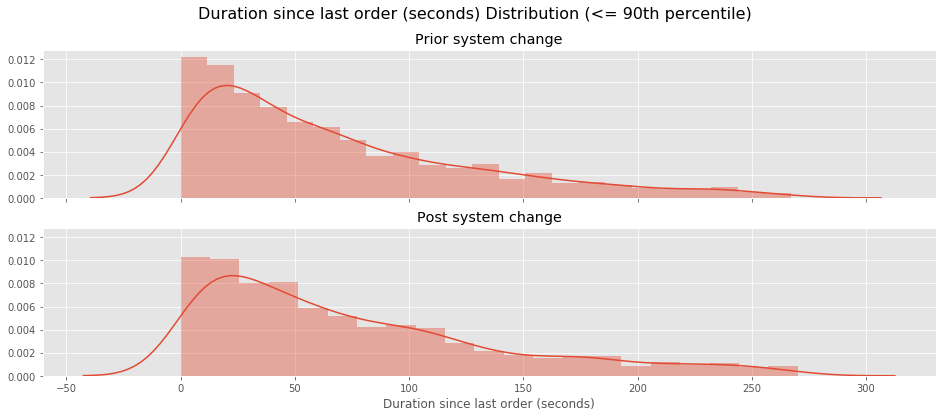

In [37]:
fig, ax = plt.subplots(nrows=2,sharex='col',sharey=True, figsize=(16,6))
sns.distplot(response_prior3['Duration last order'], ax=ax[0])
sns.distplot(response_post3['Duration last order'], ax=ax[1])
ax[0].set_xlabel('')
ax[1].set_xlabel('Duration since last order (seconds)',fontsize=12)
ax[0].set_title('Prior system change')
ax[1].set_title('Post system change')
fig.suptitle('Duration since last order (seconds) Distribution (<= 90th percentile)', fontsize=16)
plt.show()

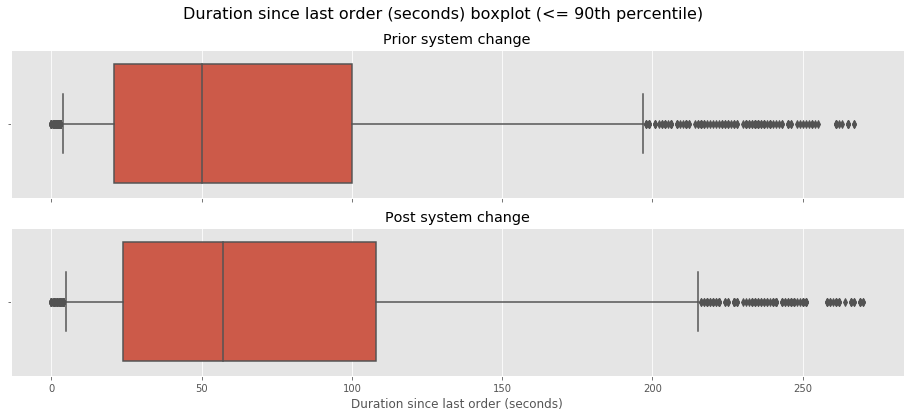

In [38]:
fig, ax = plt.subplots(nrows=2,sharex='col',sharey=True, figsize=(16,6))
sns.boxplot(x=response_prior3['Duration last order'], whis=[5, 95], ax=ax[0])
sns.boxplot(x=response_post3['Duration last order'], whis=[5, 95], ax=ax[1])
ax[0].set_xlabel('')
ax[1].set_xlabel('Duration since last order (seconds)',fontsize=12)
ax[0].set_title('Prior system change')
ax[1].set_title('Post system change')
fig.suptitle('Duration since last order (seconds) boxplot (<= 90th percentile)', fontsize=16)
plt.show()

### From the boxplot we can tell there was a shift of the distribution, the 25% percentile, median and 75% percentile shifted higher! So the duration since last order seemed to be higher after system change. To check how confident we are about the shifting of distribution. Let's perform some test statistics again.

### From the visualization, we get that the duration since last order were again not normally distributed. We will perform non-parametric test as well.

### One-tailed Mann-Whitney U Test (To check the shift of direction)

### Assumptions: 
#### 1.) All the observations are independent of each other. 
#### 2.) Dependent variables (duration since last order) are ordinal.
#### 3.) Independent variables (System change) are categorical
#### 4.) Data are not normally distributed, two distributions have the same shape (Can tell from the plots above)
<br>
#### Null hypothesis: both distributions are the same
#### Alternative hypothesis: prior distribution is less than the post distribution
#### Alpha = 1%
#### Decision rule: reject null hypothesis if p-value is lower than 1%

### For records lower or equal 90th percentile

In [39]:
print(' (<=90th percentile) Mann Whitney U Test statistics and P-value: {} and {}'.format( 
    st.mannwhitneyu(response_prior3['Duration last order'], response_post3['Duration last order'], alternative='less')[0],
    st.mannwhitneyu(response_prior3['Duration last order'], response_post3['Duration last order'], alternative='less')[1]))

 (<=90th percentile) Mann Whitney U Test statistics and P-value: 2368077.5 and 0.00014007543910409453


### For all records

In [40]:
print('(All records) Mann Whitney U Test statistics and P-value: {} and {}'.format( 
    st.mannwhitneyu(response_prior['Duration last order'], response_post['Duration last order'], alternative='less')[0],
    st.mannwhitneyu(response_prior['Duration last order'], response_post['Duration last order'], alternative='less')[1]))

(All records) Mann Whitney U Test statistics and P-value: 2962522.5 and 0.0009943276235959495


In [41]:
# Just to calculate z-stat since if sample size is large, the U statistic approximates normal distribution

u, prob = st.mannwhitneyu(response_prior['Duration last order'], response_post['Duration last order'], alternative='less')
x = response_prior['Duration last order']
y = response_post['Duration last order']

m_u = len(x)*len(y)/2

sigma_u = np.sqrt(len(x)*len(y)*(len(x)+len(y)+1)/12)

z = (u - m_u)/sigma_u
print('Z-statistic: {} < -2.325 (critical value for one tailed test with alpha 1%)'.format(z))

Z-statistic: -3.0918636802212784 < -2.325 (critical value for one tailed test with alpha 1%)


### Median of duration since last order before and after system change were 60 secs and 66 sec. We can reject the Null hypothesis since P- values (0.00099) are lower than 0.05. We can say that the duration since lasts order after system change were higher with 99% level of confidence. So the system change seemed to decrease the frequency of orders.

### Perhaps it is just an coincidence and there could be external factors affecting the demand and frequency. Were there any fees structure change or redesign of User Interface of the app after introducing the system change?

## Exploratory Data Analysis (EDA)

In [42]:
# dow names for plot mapping
dow_names = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

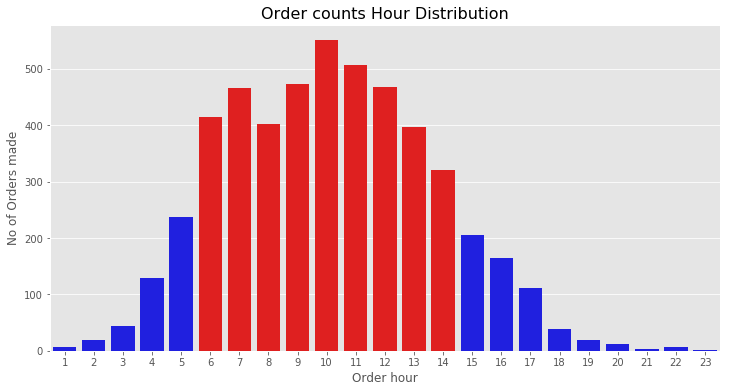

In [43]:
plt.figure(figsize=(12,6))
label = np.arange(1,24)
clrs = ['blue' if (i < 6) else ('red' if (i < 15) else 'blue') for i in label]
sns.countplot(x="Order hour", palette=clrs, data=response)
plt.title('Order counts Hour Distribution', fontsize=16)
plt.xlabel('Order hour', fontsize=12)
plt.xticks(rotation='horizontal')
plt.ylabel('No of Orders made',fontsize=12)
plt.show()

### Orders seemed to be saturated between 6 am to 2 pm. And there werent much activities during the night which makes sense since I think people usually hire vehicles for house moving, food delivery during daytime.

In [44]:
# count frequency (day of week)
date = pd.DataFrame()
date['Date'] = list
date['Day of week'] = date['Date'].apply(dt.date.weekday)
date['Day of week'].value_counts()

6    2
5    2
4    2
0    2
3    1
2    1
1    1
Name: Day of week, dtype: int64

In [45]:
# create dataframe for average orders per day of week
df = pd.DataFrame()
df['Day of week'] = range(0,7)
df['Total counts'] = response['Order dayOfweek'].value_counts()
df['Frequency'] = date['Day of week'].value_counts() 
df['Avg counts'] = df['Total counts'] / df['Frequency']
df

,Day of week,Total counts,Frequency,Avg counts
0,0,1160,2,580.0
1,1,624,1,624.0
2,2,610,1,610.0
3,3,634,1,634.0
4,4,418,2,209.0
5,5,438,2,219.0
6,6,1116,2,558.0


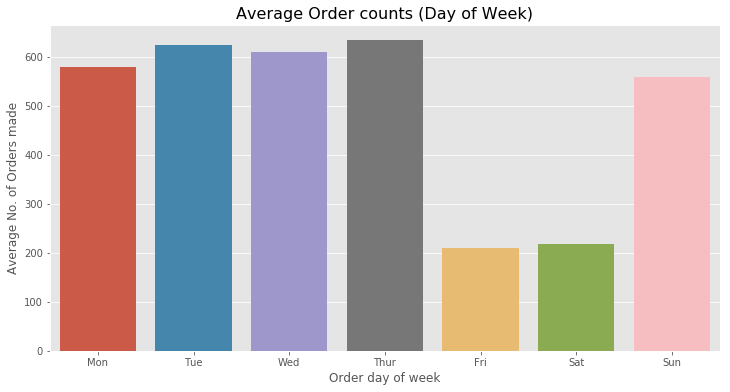

In [46]:
plt.figure(figsize=(12,6))
sns.barplot(x='Day of week', y='Avg counts', data=df)
plt.title('Average Order counts (Day of Week)', fontsize=16)
plt.xlabel('Order day of week', fontsize=12)
plt.xticks(range(0,7), dow_names, rotation='horizontal')
plt.ylabel('Average No. of Orders made',fontsize=12)
plt.show()

### On Friday and Saturday, the average total orders were significantly less than other days but we cannot draw any insight since the dataset is very small (5000) and were from only 11 days.

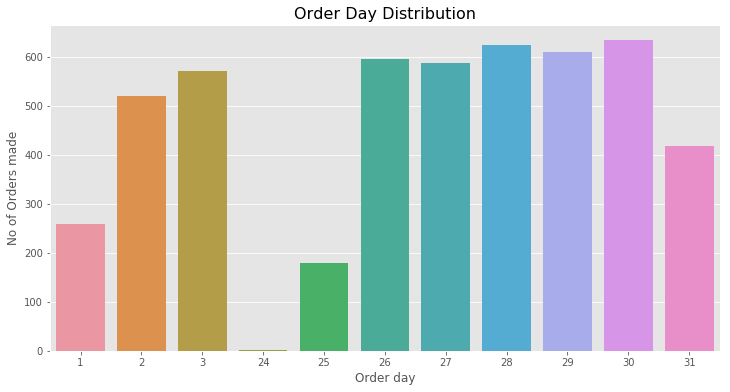

In [47]:
plt.figure(figsize=(12,6))
sns.countplot(response['Order day'])
plt.title('Order Day Distribution', fontsize=16)
plt.xlabel('Order day', fontsize=12)
plt.ylabel('No of Orders made',fontsize=12)
plt.show()

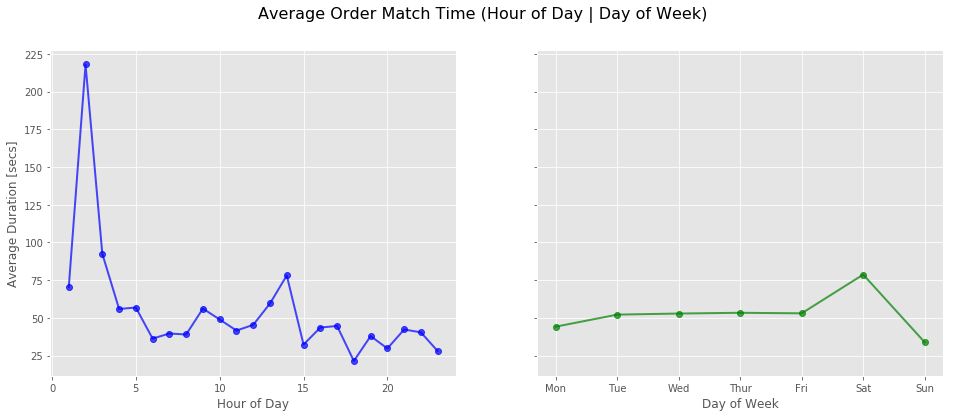

In [48]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(16,6))
ax[0].plot(response.groupby('Order hour')['Duration'].mean(), 'bo-', lw=2, alpha=0.7)
ax[1].plot(response.groupby('Order dayOfweek')['Duration'].mean(), 'go-', lw=2, alpha=0.7)

plt.sca(ax[1])
plt.xticks(range(0, 7), dow_names) #set name of label x 

ax[0].set_xlabel('Hour of Day',fontsize=12)
ax[1].set_xlabel('Day of Week',fontsize=12)

ax[0].set_ylabel('Average Duration [secs]')
fig.suptitle('Average Order Match Time (Hour of Day | Day of Week)', fontsize=16)
plt.show()

### From hour of day chart, most of the order match time were under 60 secs and took more time to match from 1 am to 3 am. And the average order match time seemed to be around the same no matter which day it is on the week.

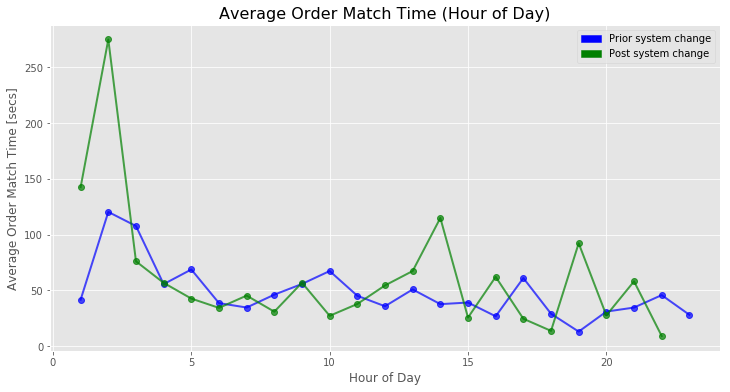

In [49]:
plt.figure(figsize=(12,6))
plt.plot(response_prior.groupby('Order hour')['Duration'].mean(), 'bo-', lw=2, alpha=0.7)
plt.plot(response_post.groupby('Order hour')['Duration'].mean(), 'go-', lw=2, alpha=0.7)

blue_patch = mpatches.Patch(color='blue', label='Prior system change')
green_patch = mpatches.Patch(color='green', label='Post system change')
plt.legend(handles=[blue_patch, green_patch])

plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Order Match Time [secs]')
plt.title('Average Order Match Time (Hour of Day)', fontsize=16)
plt.show()

In [50]:
# Check how many average order match time were lowere after system change
list = (response_prior.groupby('Order hour')['Duration'].mean() - response_post.groupby('Order hour')['Duration'].mean()).tolist()

counter = 0
for item in list:
    if item >= 0:
        counter = counter + 1
counter

11

### From the graph, it is hard to tell if there was any impact from the system change and there were less than half hour of day (11) where the average order match time were lower. So it is always good to perform statistical test to check if there is any difference in distributions (Demonstrated in Question a)

In [51]:
response_post[response_post['Order hour']==23]

,Driver Response Timestamp,Order Create Timestamp,Order Id,Duration,Duration [min],Order hour,Order dayOfweek,Order day,Duration last order,Duration last order [min]


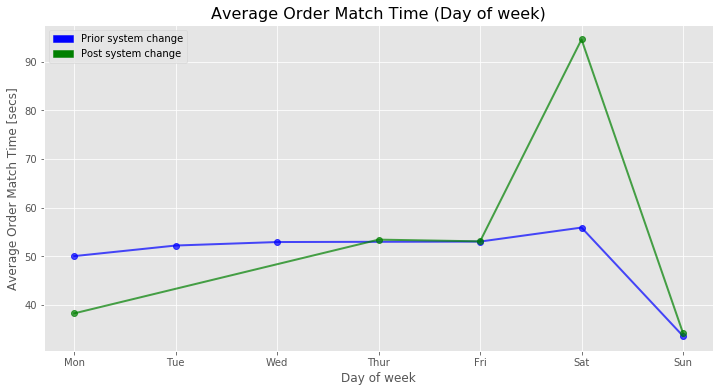

In [52]:
plt.figure(figsize=(12,6))
plt.plot(response_prior.groupby('Order dayOfweek')['Duration'].mean(), 'bo-', lw=2, alpha=0.7)
plt.plot(response_post.groupby('Order dayOfweek')['Duration'].mean(), 'go-', lw=2, alpha=0.7)

plt.xticks(range(0, 7), dow_names) #set name of label

blue_patch = mpatches.Patch(color='blue', label='Prior system change')
green_patch = mpatches.Patch(color='green', label='Post system change')
plt.legend(handles=[blue_patch, green_patch])

plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Average Order Match Time [secs]')
plt.title('Average Order Match Time (Day of week)', fontsize=16)
plt.show()

### We can also model the Order Match Time as demonstrated below

### Model the Order Match Time (prior system change)

C:\Users\edwin\Anaconda3\lib\site-packages\matplotlib\__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


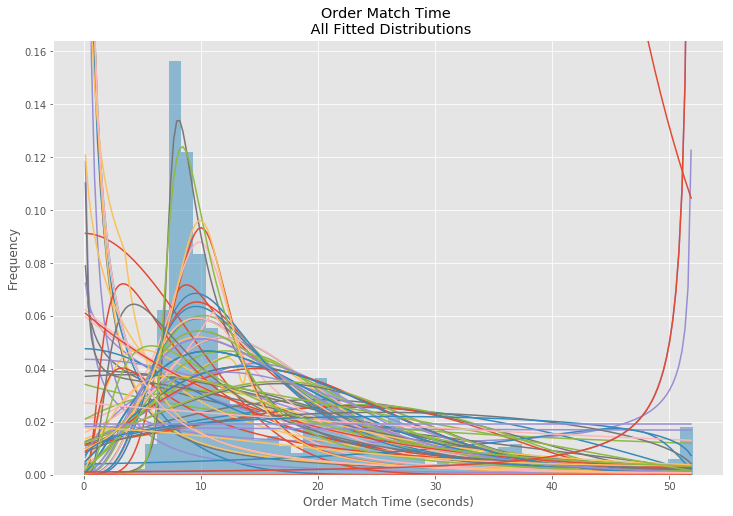

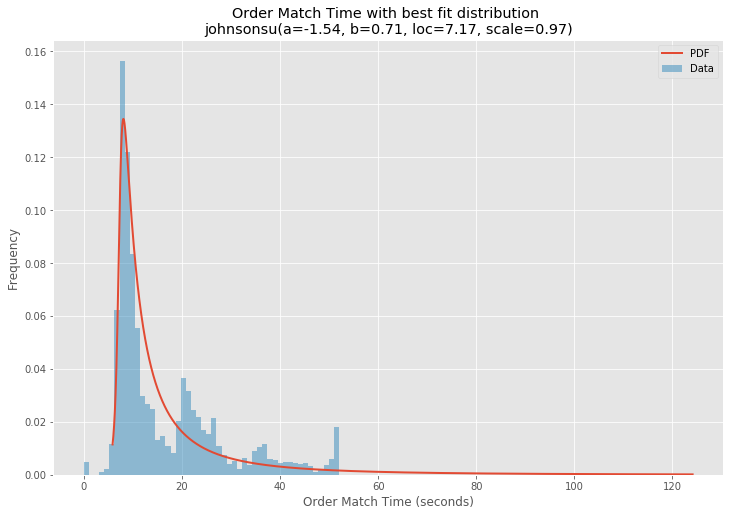

In [53]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from prior system change, using <= 90th percentile
data = pd.Series(response_prior2['Duration'].values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Order Match Time \n All Fitted Distributions')
ax.set_xlabel(u'Order Match Time (seconds)')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Order Match Time with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Order Match Time (seconds)')
ax.set_ylabel('Frequency')
plt.show()

### Model the Order Match Time (Post system change)

C:\Users\edwin\Anaconda3\lib\site-packages\matplotlib\__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


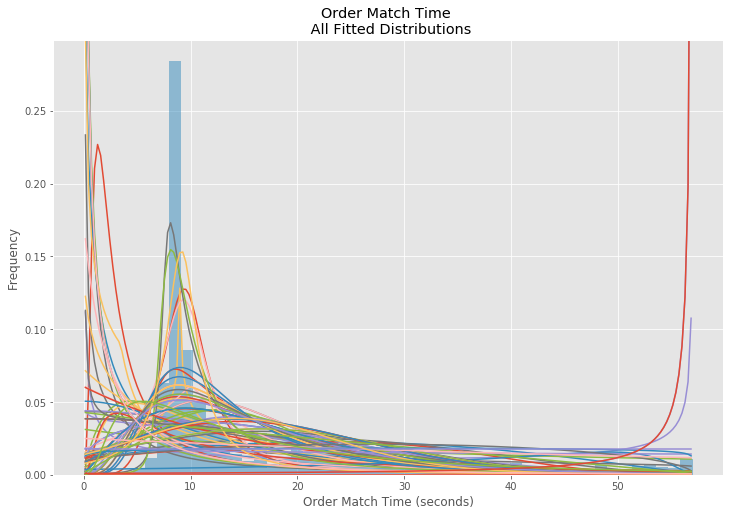

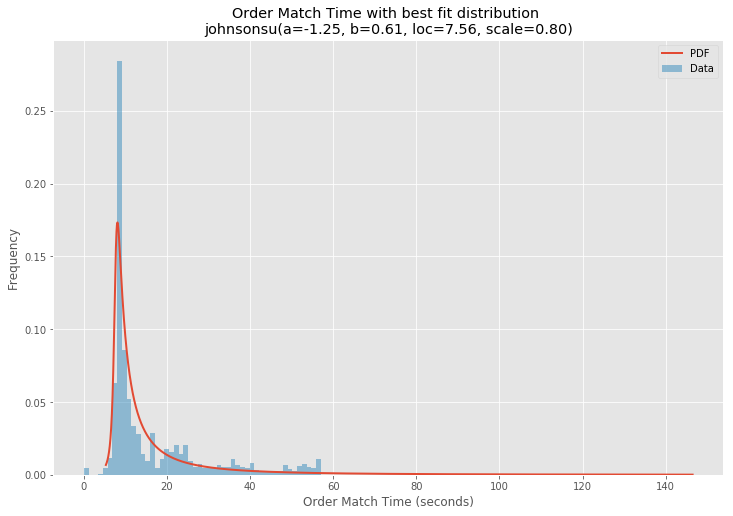

In [54]:
# Load data from post system change, using <= 90th percentile
data = pd.Series(response_post2['Duration'].values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Order Match Time \n All Fitted Distributions')
ax.set_xlabel(u'Order Match Time (seconds)')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Order Match Time with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Order Match Time (seconds)')
ax.set_ylabel('Frequency')
plt.show()

In [55]:
# model for Order Match Time (Prior system change), parameters from the graphs above
st.johnsonsu.cdf(20, -1.54, 0.71, loc=7.17, scale=0.97)

0.7842247363864613

In [56]:
# model for Order Match Time (Post system change), parameters from the graphs above
st.johnsonsu.cdf(20, -1.25, 0.61, loc=7.56, scale=0.8)

0.8015934128018399

### After modelling, we can calculate the cumulative probabilty of Order Match Time as shown above (20 seconds) and compare them. For Order Match Time of 20 seconds, the cumulative probability is higher for Order Match Time post system change (0.8016) vs. (0.7842) prior system change. Another way to show that that there were more orders matching (under certain time, e.g. 20 seconds) post system change!
<br>

## Question c) Any observations regarding the testing process or environment? How would you improve or redesign this experiment?

### There were no parallel testing environment (controlled experiment), it is hard to judge whether the shift in order match time distributions were due to the system change or other external factors. 

### In order to improve the experiment, we can implement A/B testing, which is testing different versions of the order matching system at the same time and the only different variable is the change introduced at 2017-03-30 12:00:00 am.

### We have to assign equal probability (50/50) for lalamove customers to go through either the original order matching system (controlled) or the upgraded order matching system (treatment). To get more accurate results, we can also limit the vehicle hiring type to only van and exclude all the other vehicles hiring (motorcycle and truck) for this particular experiment. Since there may be different algorithms for matching different vehicles or the supply of drivers vary between different vehicle types.

### After collecting enough data points, we can go through the Mann-Whitney U test demonstrated in question a and b. This time we can be more certain about the statistical result since we are running two versions of system at the same time and all the external factors should be the same for both groups.
<br>

## Thank you for reading! Hopefully my analysis is interesting and detailed enough! I had fun doing the SQL challenge and writing this notebook! I wish I have more data to look at! Hope to meet everyone at Lalamove soon!